In [1]:
!pip install pinnstorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.0 MB/s eta 0:00:00
  Created wheel for pinnstorch: filename=pinnstorch-0.1.2-py3-none-any.whl size=71565 sha256=9b0a26d78927a3735bb407f89b535a791e7f6c1918610843726c4d97eb851aee
  Stored in directory: /root/.cache/pip/wheels/a0/c2/4a/53704ce64bcfa1416dcd2b1968bb35d63ac62b9a64d4eeec69
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=ab6c9b4415a1f57b198774ce16cd8d89164a640789101caeae62ba013ccf81d9
  Stored in directory: /root/.cache/pip/wheels/96/b9/5d/1138ea8c8f212bce6e97ae58847b7cc323145b3277f2129e2b
Successfully built pinnstorch pyDOE


In [2]:
!pip install pinnstorch

Iter 0, Loss Adam: 1.1911742687225342
Iter 100, Loss Adam: 0.3270370066165924
Iter 200, Loss Adam: 0.12865345180034637
Iter 300, Loss Adam: 0.0792902410030365
Iter 400, Loss Adam: 0.06446526944637299
Iter 500, Loss Adam: 0.05786944553256035
Iter 600, Loss Adam: 0.053594306111335754
Iter 700, Loss Adam: 0.05022773891687393
Iter 800, Loss Adam: 0.046731751412153244
Iter 900, Loss Adam: 0.04358966648578644
Iter 1000, Loss Adam: 0.04029000177979469
Iter 1100, Loss Adam: 0.03780318796634674
Iter 1200, Loss Adam: 0.03582338988780975
Iter 1300, Loss Adam: 0.03434146195650101
Iter 1400, Loss Adam: 0.03292816877365112
Iter 1500, Loss Adam: 0.031921178102493286
Iter 1600, Loss Adam: 0.030834214761853218
Iter 1700, Loss Adam: 0.02972523868083954
Iter 1800, Loss Adam: 0.02896789275109768
Iter 1900, Loss Adam: 0.02787455916404724
Iter 2000, Loss Adam: 0.02877614088356495
Iter 2100, Loss Adam: 0.026340577751398087
Iter 2200, Loss Adam: 0.025246046483516693
Iter 2300, Loss Adam: 0.024525417014956474


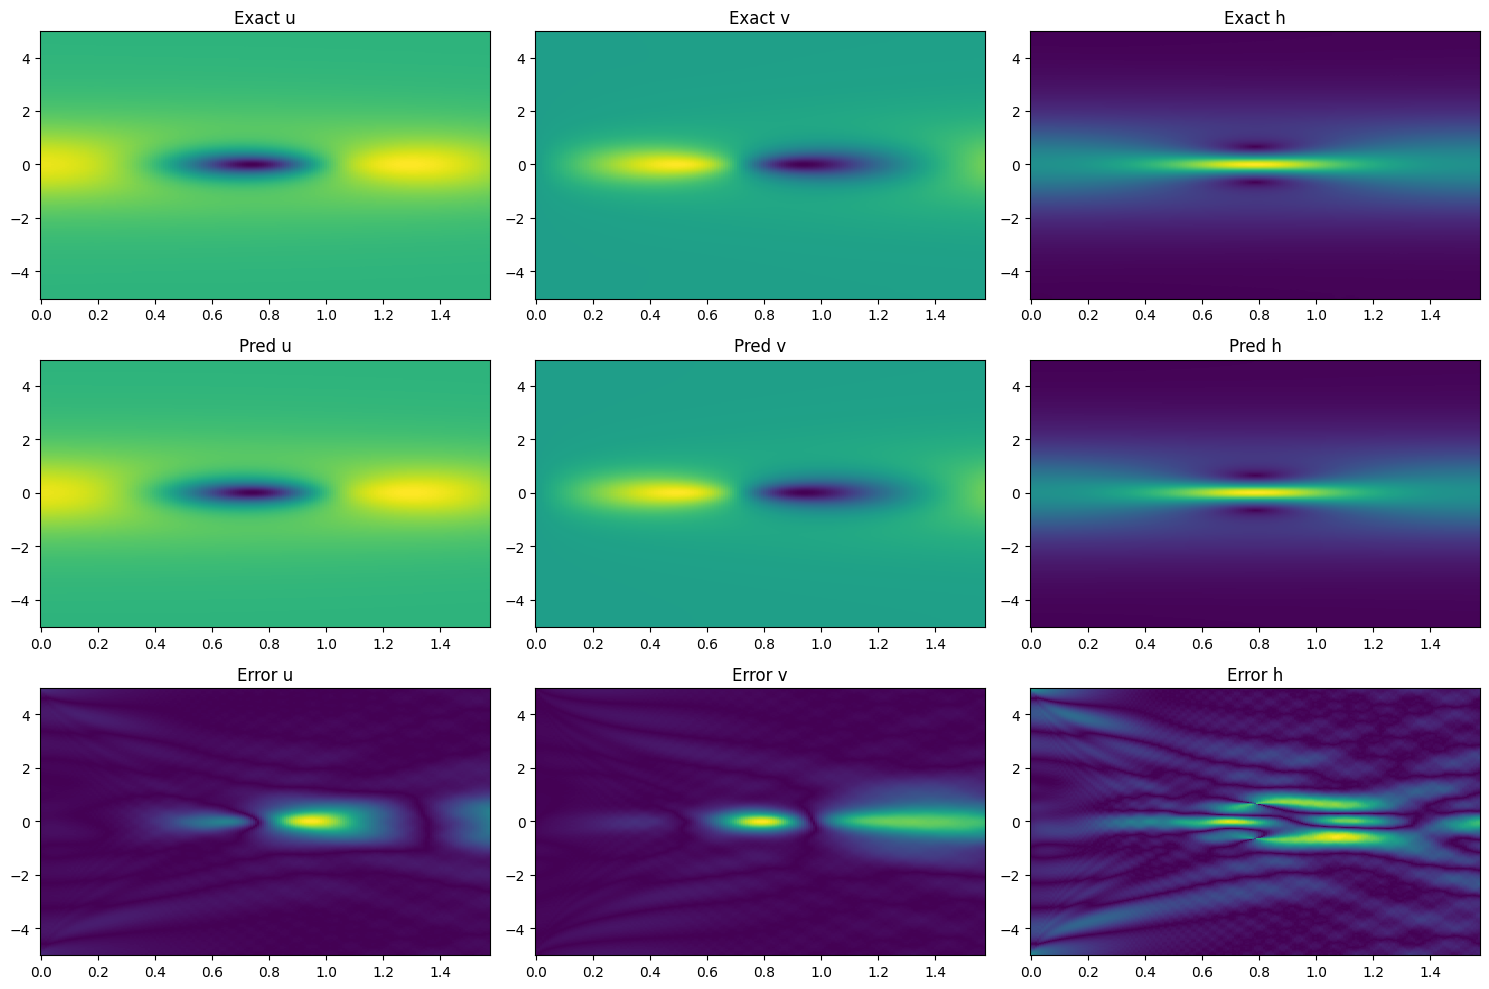

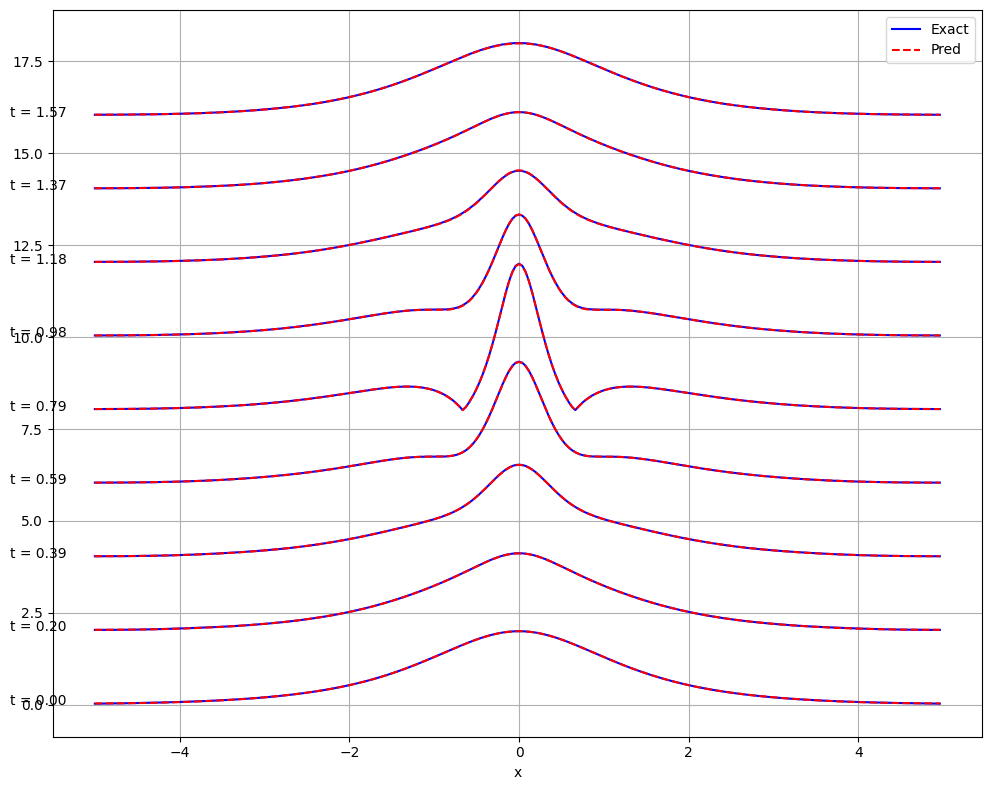

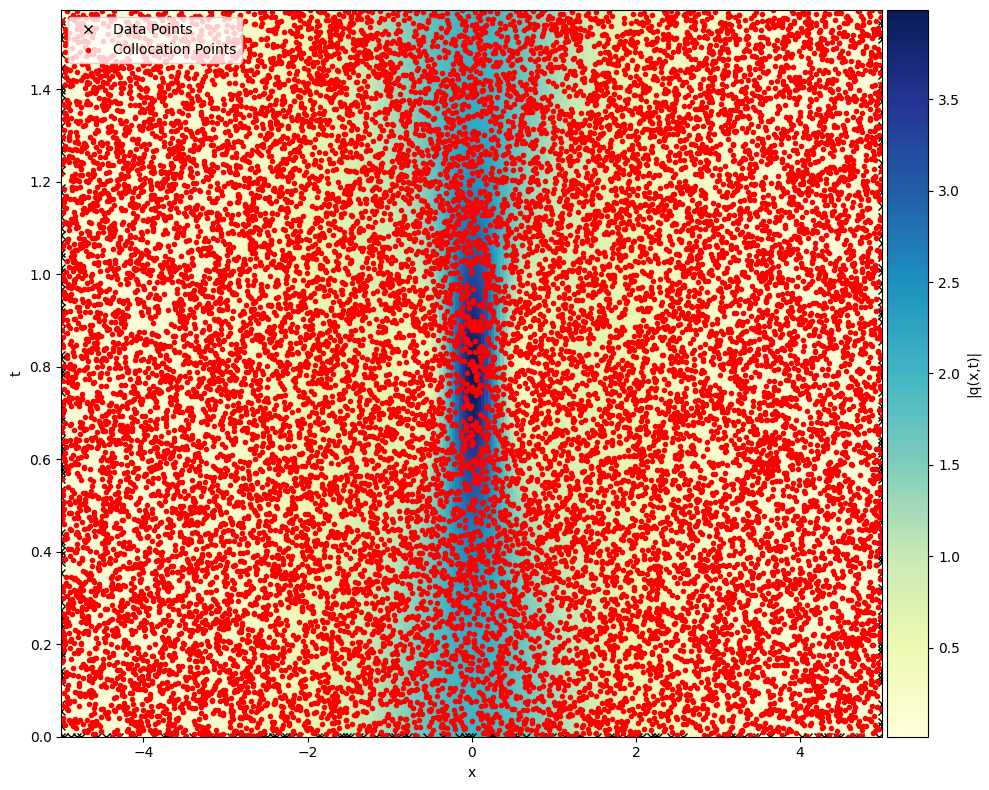

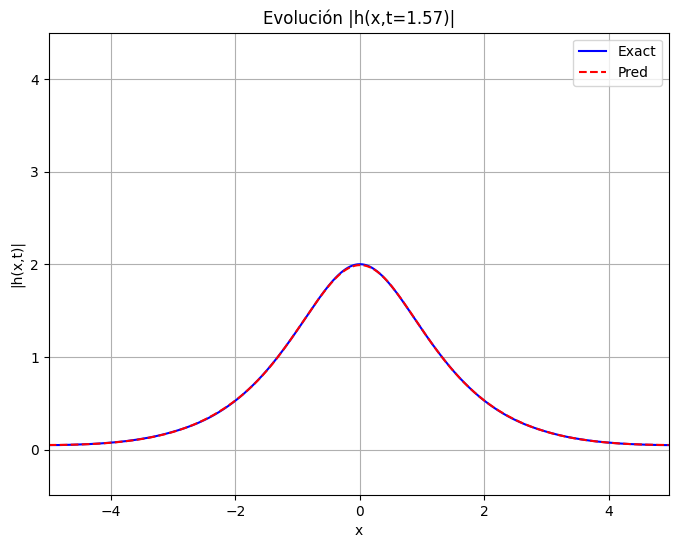

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from pyDOE import lhs
import time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = scipy.io.loadmat('NLS.mat')
t = data['tt'].flatten()[:, None]  
x = data['x'].flatten()[:, None]  
Exact = data['uu'] 
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u ** 2 + Exact_v ** 2)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]


lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
N0 = 100
N_b = 100
N_f = 20000
layers = [2, 40, 40, 40, 2]

idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x, :]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t, :]

X_f = lb + (ub - lb) * lhs(2, N_f)
X0 = np.concatenate((x0, 0 * x0), 1)
X_lb = np.concatenate((0 * tb + lb[0], tb), 1)
X_ub = np.concatenate((0 * tb + ub[0], tb), 1)
X_u_train = np.vstack([X0, X_lb, X_ub])


X_star_t = torch.tensor(X_star, dtype=torch.float32).to(device)
x0_t = torch.tensor(X0[:, 0:1], dtype=torch.float32).to(device)
t0_t = torch.tensor(X0[:, 1:2], dtype=torch.float32).to(device)
u0_t = torch.tensor(u0, dtype=torch.float32).to(device)
v0_t = torch.tensor(v0, dtype=torch.float32).to(device)
x_lb_t = torch.tensor(X_lb[:, 0:1], dtype=torch.float32).to(device)
t_lb_t = torch.tensor(X_lb[:, 1:2], dtype=torch.float32).to(device)
x_ub_t = torch.tensor(X_ub[:, 0:1], dtype=torch.float32).to(device)
t_ub_t = torch.tensor(X_ub[:, 1:2], dtype=torch.float32).to(device)
x_f_t = torch.tensor(X_f[:, 0:1], dtype=torch.float32).to(device)
t_f_t = torch.tensor(X_f[:, 1:2], dtype=torch.float32).to(device)

class PINN(nn.Module):
    def __init__(self, layers, lb, ub):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.lb = torch.tensor(lb, dtype=torch.float32).to(device)
        self.ub = torch.tensor(ub, dtype=torch.float32).to(device)
        self.activation = nn.Tanh()

    def forward(self, X):
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for layer in self.layers[:-1]:
            H = self.activation(layer(H))
        return self.layers[-1](H)

def get_derivatives(model, x, t, order=1):
    x.requires_grad_(True)
    t.requires_grad_(True)
    uv = model(torch.cat([x, t], dim=1))
    u = uv[:, 0:1]
    v = uv[:, 1:2]
    if order == 1:
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        return u, v, u_x, v_x
    else:
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        return u, v, u_t, v_t, u_xx, v_xx

def loss_fn(model, x0, t0, u0, v0, x_lb, t_lb, x_ub, t_ub, x_f, t_f):
    u0_pred, v0_pred, _, _ = get_derivatives(model, x0, t0)
    u_lb, v_lb, u_x_lb, v_x_lb = get_derivatives(model, x_lb, t_lb)
    u_ub, v_ub, u_x_ub, v_x_ub = get_derivatives(model, x_ub, t_ub)
    u_f, v_f, u_t, v_t, u_xx, v_xx = get_derivatives(model, x_f, t_f, order=2)
    f_u = u_t + 0.5 * v_xx + (u_f**2 + v_f**2) * v_f
    f_v = v_t - 0.5 * u_xx - (u_f**2 + v_f**2) * u_f
    loss = torch.mean((u0 - u0_pred)**2) + torch.mean((v0 - v0_pred)**2) + \
           torch.mean((u_lb - u_ub)**2) + torch.mean((v_lb - v_ub)**2) + \
           torch.mean((u_x_lb - u_x_ub)**2) + torch.mean((v_x_lb - v_x_ub)**2) + \
           torch.mean(f_u**2) + torch.mean(f_v**2)
    return loss

model = PINN(layers, lb, ub).to(device)
optimizer_adam = torch.optim.Adam(model.parameters())

start_time = time.time()


for it in range(10000):
    optimizer_adam.zero_grad()
    loss = loss_fn(model, x0_t, t0_t, u0_t, v0_t, x_lb_t, t_lb_t, x_ub_t, t_ub_t, x_f_t, t_f_t)
    loss.backward()
    optimizer_adam.step()
    if it % 100 == 0:
        print(f'Iter {it}, Loss Adam: {loss.item()}')


optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=10000, history_size=50, line_search_fn="strong_wolfe")

def closure():
    optimizer_lbfgs.zero_grad()
    loss = loss_fn(model, x0_t, t0_t, u0_t, v0_t, x_lb_t, t_lb_t, x_ub_t, t_ub_t, x_f_t, t_f_t)
    loss.backward()
    return loss

optimizer_lbfgs.step(closure)

elapsed = time.time() - start_time
print('Training time:', elapsed)


with torch.no_grad():
    uv_pred = model(X_star_t)
    u_pred = uv_pred[:, 0:1].cpu().numpy()
    v_pred = uv_pred[:, 1:2].cpu().numpy()
    h_pred = np.sqrt(u_pred ** 2 + v_pred ** 2)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_h = np.linalg.norm(h_star - h_pred, 2) / np.linalg.norm(h_star, 2)
print(f'Error u: {error_u}, Error v: {error_v}, Error h: {error_h}')


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
U_star_grid = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
V_star_grid = griddata(X_star, v_star.flatten(), (X, T), method='cubic')
H_star_grid = griddata(X_star, h_star.flatten(), (X, T), method='cubic')


np.savez_compressed('PINN_results.npz',
    x=X[0, :],                  # x-axis
    t=T[:, 0],                  # t-axis
    X=X,
    T=T,
    Exact_h=Exact_h,
    U_star=U_star_grid,
    V_star=V_star_grid,
    H_star=H_star_grid,
    U_pred=U_pred,
    V_pred=V_pred,
    H_pred=H_pred,
    X_u_train=X_u_train,
    X_f=X_f,
    lb=lb,
    ub=ub,
    error_u=error_u,
    error_v=error_v,
    error_h=error_h
)

metadata = {
    'layers': layers,
    'N0': int(N0),
    'Nb': int(N_b),
    'Nf': int(N_f),
    'lb': lb.tolist(),
    'ub': ub.tolist(),
    'error_u': float(error_u),
    'error_v': float(error_v),
    'error_h': float(error_h),
    'training_time_sec': float(elapsed)
}

with open('PINN_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)




fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs[0,0].pcolormesh(T, X, U_star_grid, cmap='viridis')
axs[0,0].set_title('Exact u')
axs[0,1].pcolormesh(T, X, V_star_grid, cmap='viridis')
axs[0,1].set_title('Exact v')
axs[0,2].pcolormesh(T, X, H_star_grid, cmap='viridis')
axs[0,2].set_title('Exact h')

axs[1,0].pcolormesh(T, X, U_pred, cmap='viridis')
axs[1,0].set_title('Pred u')
axs[1,1].pcolormesh(T, X, V_pred, cmap='viridis')
axs[1,1].set_title('Pred v')
axs[1,2].pcolormesh(T, X, H_pred, cmap='viridis')
axs[1,2].set_title('Pred h')

axs[2,0].pcolormesh(T, X, np.abs(U_star_grid - U_pred), cmap='viridis')
axs[2,0].set_title('Error u')
axs[2,1].pcolormesh(T, X, np.abs(V_star_grid - V_pred), cmap='viridis')
axs[2,1].set_title('Error v')
axs[2,2].pcolormesh(T, X, np.abs(H_star_grid - H_pred), cmap='viridis')
axs[2,2].set_title('Error h')
plt.tight_layout()
plt.savefig('pytorch_u_v_h_errors.pdf')
plt.show()


fig_stack, ax = plt.subplots(figsize=(10, 8))
cut_indices = np.linspace(0, len(t) - 1, 9, dtype=int)
for i, idx in enumerate(cut_indices):
    vertical_offset = i * 2.0
    ax.plot(x, Exact_h[:, idx] + vertical_offset, 'b-', label='Exact' if i == 0 else None)
    ax.plot(x, H_pred[idx, :] + vertical_offset, 'r--', label='Pred' if i == 0 else None)
    ax.text(x.min() - 1, vertical_offset, f't = {t[idx, 0]:.2f}', fontsize=10)
ax.set_xlabel('x')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.savefig('pytorch_time_slices.pdf')
plt.show()


fig_data, ax = plt.subplots(figsize=(10, 8))
h_img = ax.imshow(H_pred, extent=[lb[0], ub[0], lb[1], ub[1]], origin='lower', aspect='auto', cmap='YlGnBu')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig_data.colorbar(h_img, cax=cax, label='|q(x,t)|')
ax.plot(X_u_train[:, 0], X_u_train[:, 1], 'kx', label='Data Points')
ax.plot(X_f[:, 0], X_f[:, 1], 'r.', label='Collocation Points')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.tight_layout()
plt.savefig('pytorch_data_points.pdf')
plt.show()


fig_anim, ax_anim = plt.subplots(figsize=(8, 6))
line_exact, = ax_anim.plot(x, Exact_h[:, 0], 'b-', label='Exact')
line_pred, = ax_anim.plot(x, H_pred[0, :], 'r--', label='Pred')
ax_anim.set_xlim(x.min(), x.max())
ax_anim.set_ylim(Exact_h.min() - 0.5, Exact_h.max() + 0.5)
ax_anim.set_xlabel('x')
ax_anim.set_ylabel('|h(x,t)|')
ax_anim.legend()
ax_anim.grid(True)

def animate(i):
    line_exact.set_ydata(Exact_h[:, i])
    line_pred.set_ydata(H_pred[i, :])
    ax_anim.set_title(f'Evolución |h(x,t={t[i, 0]:.2f})|')
    return line_exact, line_pred

anim = FuncAnimation(fig_anim, animate, frames=len(t), interval=100, blit=True, repeat=True)
anim.save('pytorch_nlse_evolution.gif', writer='pillow', fps=10)
plt.show()